In [267]:
""" 
Question 1:
Download the dataset, where the first four columns are features, and the last column
corresponds to categories (3 labels). Perform the following tasks.
"""

import numpy as np
import pandas as pd


In [268]:
class GaussianNBClassifierFromScratch():
    def calcPrior(self, features: pd.DataFrame, target: pd.DataFrame):
        self.prior = (features.groupby(target).apply(
            lambda x: len(x)) / self.dataCount).to_numpy()
        return self.prior

    def calcStatistics(self, features: pd.DataFrame, target: pd.DataFrame):
        self.mean = features.groupby(target).apply(np.mean).to_numpy()
        self.var = features.groupby(target).apply(np.var).to_numpy()
        return self.mean, self.var

    def gaussianDensity(self, class_idx, x):
        '''
        (1/√2pi*σ) * exp((-1/2)*((x-μ)^2)/(2*σ²))
        '''
        mean = self.mean[class_idx]
        var = self.var[class_idx]
        numerator = np.exp((-1/2)*((x-mean)**2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        prob = numerator / denominator
        return prob

    def calcPosterior(self, x):
        posteriors = []

        # calculate posterior probability for each class
        for i in range(self.classCount):
            prior = self.prior[i]
            conditional = np.prod(self.gaussianDensity(i, x))

            #print('posteriors for [{}], prob ==> [{}]'.format(x, self.gaussianDensity(i, x)))
            #print('posteriors for [{}], cond ==> [{}]'.format(x, conditional))
            posterior = prior * conditional
            posteriors.append(posterior)

        #print('posteriors for [{}]==> [{}]'.format(x, posteriors))
        return posteriors

    def fit(self, features: pd.DataFrame, target: pd.DataFrame):
        self.classes = np.unique(target)
        self.classCount = len(self.classes)
        self.featureCount = features.shape[1]
        self.dataCount = features.shape[0]

        self.calcStatistics(features, target)
        self.calcPrior(features, target)

        print('GaussianNBClassifier trained :')
        print('\t mean ==> {}'.format(self.mean))
        print('\t var ==> {}'.format(self.var))
        print('\t prior ==> {}'.format(self.prior))

    def predict(self, features):
        classProbabilities = self.predictProbabilities(features)
        # return class with highest posterior probability
        return np.array([self.classes[np.argmax(cp)] for cp in classProbabilities])

    def predictProbabilities(self, features):

        return np.array([self.calcPosterior(f) for f in features.to_numpy()])


In [269]:

from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'axes.facecolor': 'lightblue', 'figure.facecolor': 'lightblue'})


def confusionMatrixAndAccuracyReport(Y_test, Y_pred):
    cm = metrics.confusion_matrix(Y_test, Y_pred)
    overallAccuracy = np.trace(cm)/sum(cm.flatten())

    classwiseAccuracy = np.zeros(len(cm))
    for n in range(len(cm)):
        for i in range(len(cm)):
            for j in range(len(cm)):
                if (i != n and j != n) or (i == n and j == n):
                    classwiseAccuracy[n] += cm[i][j]

    classwiseAccuracy /= sum(cm.flatten())

    plt.figure(figsize=(6, 6))
    plt.title('Accuracy Score: {0:3.3f}'.format(overallAccuracy), size=12)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    sns.heatmap(data=cm, annot=True, square=True,  cmap='Blues')

    plt.show()
    print('Overall Accuracy Score: {0:3.3f}'.format(overallAccuracy))
    print('Classwise Accuracy Score: {0}'.format(classwiseAccuracy))


In [270]:
def rocCurveAndAucAnalysis(y_test, y_score):
    n_classes = y_test.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    plt.title("ROC Curve")
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2,
             color='r', label='Random', alpha=.8)

    colors = ["aqua", "darkorange", "cornflowerblue"]
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=2,
            label="ROC curve of class {0} (area = {1:0.2f})".format(
                i, roc_auc[i]),
        )

    plt.xlabel("False Positve Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    for i in range(n_classes):
        print("Area Under the curve for class {} : {}".format(i, roc_auc[i]))


In [271]:
# Data load

data = pd.read_csv('data-ques-1/iris_dataset.csv')
data.head()


,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [272]:

# 1. Split the dataset into train and test sets (80:20)

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

X = data.drop("variety", axis=1)
Y = data["variety"]
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=23)


print('Given data set==> {}'.format(data.shape))
print('Train data set==> {}'.format(X_train.shape))
print('Test data set==> {}'.format(X_test.shape))
# for use in roc analysis
y_test_bin = label_binarize(Y_test, classes=np.unique(Y_test))


Given data set==> (150, 5)
Train data set==> (120, 4)
Test data set==> (30, 4)


In [273]:

# 2. Construct the Naive Bayes classifier from scratch and train it on the train set. Assume Gaussian distribution to compute probabilities.

modelFromScratch = GaussianNBClassifierFromScratch()
modelFromScratch.fit(X_train, Y_train)
Y_pred = modelFromScratch.predict(X_test)
y_score = modelFromScratch.predictProbabilities(X_test)


GaussianNBClassifier trained :
	 mean ==> [[4.98157895 3.41578947 1.43684211 0.24473684]
 [5.89761905 2.74761905 4.24285714 1.33095238]
 [6.57       2.9725     5.5725     2.03      ]]
	 var ==> [[0.12781856 0.1565928  0.02811634 0.01299861]
 [0.26451814 0.10344671 0.22244898 0.03975624]
 [0.4181     0.11649375 0.32799375 0.0741    ]]
	 prior ==> [0.31666667 0.35       0.33333333]


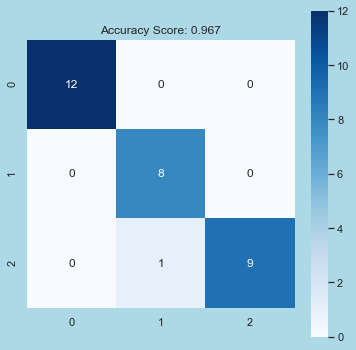

Overall Accuracy Score: 0.967
Classwise Accuracy Score: [1.         0.96666667 0.96666667]


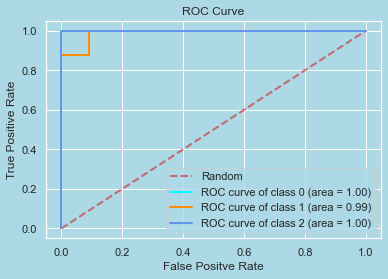

Area Under the curve for class 0 : 1.0
Area Under the curve for class 1 : 0.9886363636363636
Area Under the curve for class 2 : 1.0


In [274]:
'''
3. Evaluate the performance using the following metric on the test set
    a. Confusion matrix
    b. Overall and class-wise accuracy
    c. ROC curve, AUC
'''
confusionMatrixAndAccuracyReport(Y_test, Y_pred)

rocCurveAndAucAnalysis(y_test_bin, y_score)


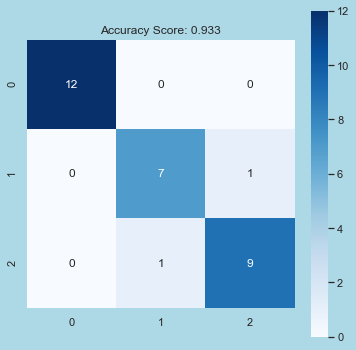

Overall Accuracy Score: 0.933
Classwise Accuracy Score: [1.         0.93333333 0.93333333]


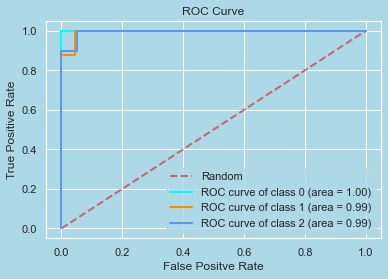

Area Under the curve for class 0 : 1.0
Area Under the curve for class 1 : 0.9943181818181819
Area Under the curve for class 2 : 0.995


In [275]:

# 4. Use any library (e.g. scikit-learn) and repeat 1 to 3

from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, Y_train)
Y_pred_lib = model.predict(X_test)
y_score_lib = model.predict_proba(X_test)


confusionMatrixAndAccuracyReport(Y_test, Y_pred_lib)

rocCurveAndAucAnalysis(y_test_bin, y_score_lib)


In [278]:
def calculateBayesRisk(lossMatrix, class_prob):
    no_of_classses = len(class_prob)
    alpha = np.zeros([no_of_classses,no_of_classses])
    for x in range(no_of_classses):
        for r in range(no_of_classses):
            alpha[x][r]=((lossMatrix[x][r] * 1 * class_prob[r])/class_prob[r])

    max_r = np.argmax(alpha,axis=0)

    for x in range(no_of_classses):
        print(
        f"The optimized value of r_x{x+1} is R{max_r[x]+1}_alpha_x{x+1} which is {alpha[x][max_r[x]]}")

    risk = 0
    for x in range(no_of_classses):
        risk+= class_prob[x]*alpha[x][max_r[x]]

    return risk


In [279]:
""" 
6. Calculate the Bayes risk.
    Consider,
    λ =
        2 4 6
        1 2 3
        6 4 1

    Where λ is a loss function and rows and columns corresponds to classes (ci) and actions (aj) respectively, e.g. λ(a3/ c2) =4.
 """
lambda_ = np.array(
    [[2, 1, 6],
     [4, 2, 4],
     [6, 3, 1]]
)


bayes_risk = calculateBayesRisk(lambda_, modelFromScratch.prior)
print(f"bayes risk {bayes_risk:.4f}")


The optimized value of r_x1 is R3_alpha_x1 which is 6.0
The optimized value of r_x2 is R3_alpha_x2 which is 4.0
The optimized value of r_x3 is R1_alpha_x3 which is 6.0
bayes risk 5.3000
